Analyzing the prediction of the training data

In [27]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import joblib
import config

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score


In [28]:
# CHANGE HERE TO TEST A DIFFERENT MODEL ########################################
model = joblib.load("models/xgboost_with_lasso_erroring")

X_train = joblib.load(config.X_TRAIN_PATH)
y_train = joblib.load(config.Y_TRAIN_PATH)
X_test = joblib.load(config.X_TEST_PATH)
y_test = joblib.load(config.Y_TEST_PATH)
feature_names = joblib.load(config.FEATURE_NAMES)

c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


True Positives (TP): 0
False Positives (FP): 0
True Negatives (TN): 329
False Negatives (FN): 67
AUC-ROC Score: 0.5000


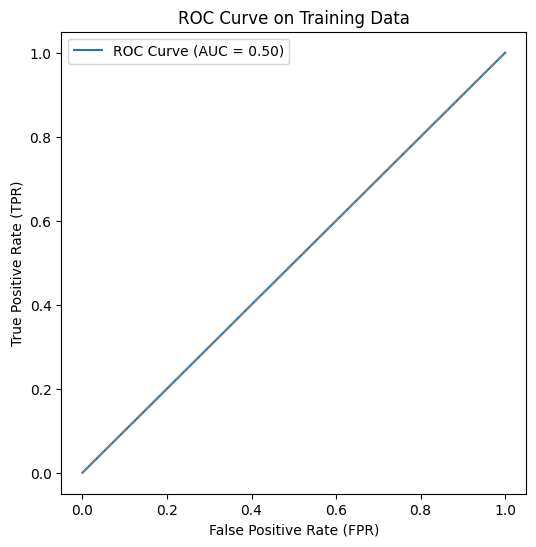

In [29]:
X_train.columns = [None] * X_train.shape[1]
y_train_pred = model.predict(X_train)

cm_test = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = cm_test.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Compute the AUC-ROC score
roc_auc = roc_auc_score(y_train, y_train_pred)

# Print the AUC-ROC score
print(f"AUC-ROC Score: {roc_auc:.4f}")


# Compute ROC curve
fpr, tpr, _ = roc_curve(y_train, y_train_pred)

# Plot the ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve on Training Data")
plt.legend()
plt.show()

Analyzing the performace on the training data

True Positives (TP): 0
False Positives (FP): 0
True Negatives (TN): 82
False Negatives (FN): 17
AUC-ROC Score: 0.5000


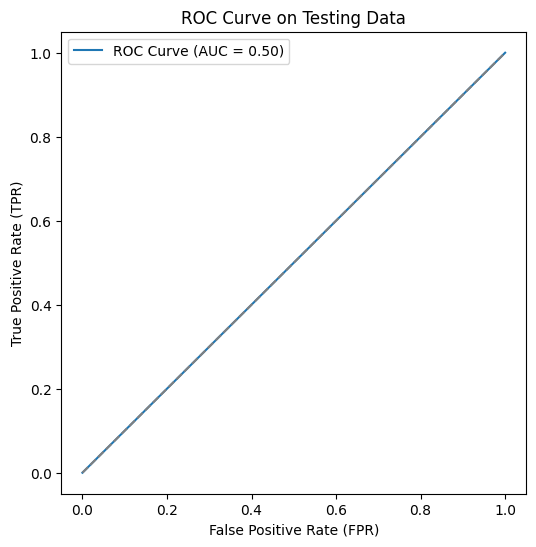

In [30]:
y_test_pred = model.predict(X_test)

cm_test = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm_test.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Compute the AUC-ROC score
roc_auc = roc_auc_score(y_test, y_test_pred)

# Print the AUC-ROC score
print(f"AUC-ROC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)

# Plot the ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve on Testing Data")
plt.legend()
plt.show()

In [31]:
# # Top Feature Analysis for Random Forest Classifier

# # Step 1: get mask from VarianceThreshold
# vt = model.named_steps["variance_threshold"]
# vt_mask = vt.get_support()
# vt_features = feature_names[vt_mask]  # surviving features after variance threshold

# # Step 2: get mask from SelectKBest
# skb = model.named_steps["select"]
# skb_mask = skb.get_support()
# skb_features = vt_features[skb_mask]  # surviving features after SelectKBest

# # Step 3: get feature importances from RandomForest
# clf = model.named_steps["clf"]
# importances = clf.feature_importances_

# # Step 4: zip names + importances
# feature_importances = sorted(
#     zip(skb_features, importances),
#     key=lambda x: x[1],
#     reverse=True
# )

# # Display top features
# print("Top 10 features:")
# for feat, score in feature_importances[:10]:
#     print(f"{feat}: {score:.4f}")

In [32]:
def analyze_top_features(model, feature_names, top_n=15):
    """
    Analyze top features for a fitted sklearn pipeline with feature selection + classifier.
    Works for RandomForest (feature_importances_) and LogisticRegression (coef_).
    
    Parameters
    ----------
    model : fitted sklearn Pipeline
        The best estimator (e.g., from GridSearchCV.best_estimator_).
    feature_names : array-like
        Original feature names before feature selection.
    top_n : int
        Number of top positive/negative features to display.
    """

    # Step 1: VarianceThreshold
    vt = model.named_steps.get("variance_threshold")
    if vt is not None:
        vt_mask = vt.get_support()
        vt_features = feature_names[vt_mask]
    else:
        vt_features = feature_names

    # Step 2: SelectKBest
    skb = model.named_steps.get("select")
    if skb is not None:
        skb_mask = skb.get_support()
        skb_features = vt_features[skb_mask]
    else:
        skb_features = vt_features

    # Step 3: Classifier
    clf = model.named_steps["clf"]

    # --- Case 1: Tree-based models ---
    if hasattr(clf, "feature_importances_"):
        importances = clf.feature_importances_
        df = pd.DataFrame({
            "feature": skb_features,
            "importance": importances
        }).sort_values("importance", ascending=False)

        print(f"\nTop {top_n} features (importance only):")
        print(df.head(top_n))

        return df

    # --- Case 2: Linear models (e.g. Logistic Regression) ---
    elif hasattr(clf, "coef_"):
        if clf.coef_.shape[0] == 1:  
            coefs = clf.coef_[0]  # binary classification
        else:
            coefs = np.mean(clf.coef_, axis=0)  # average for multiclass

        df = pd.DataFrame({
            "feature": skb_features,
            "coefficient": coefs
        }).sort_values("coefficient", ascending=False)

        print(f"\nTop {top_n} POSITIVE features (increase recurrence likelihood):")
        print(df.head(top_n))

        print(f"\nTop {top_n} NEGATIVE features (protective against recurrence):")
        print(df.tail(top_n))

        return df

    else:
        raise ValueError("Classifier does not expose feature_importances_ or coef_")

analyze_top_features(model, feature_names)

KeyError: 'clf'